### Connect with google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! ls gdrive/MyDrive

 code  'Colab Notebooks'   data   images   models


### import the libraries

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.spatial.distance import cdist

### Pretrained ResNet-50 Model

In [ ]:
BACKBONE = 'resnet50'
class ResNetFreezed(nn.Module):
    def __init__(self, freeze_param=True):
        super(ResNetFreezed, self).__init__()
        if BACKBONE == "resnet34":
            self.backbone = torchvision.models.resnet34(pretrained=True)
        if BACKBONE == "resnet50":
            self.backbone = torchvision.models.resnet50(pretrained=True)
        if BACKBONE == "resnet101":
            self.backbone = torchvision.models.resnet101(pretrained=True)
        state_dict = self.backbone.state_dict()
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        if freeze_param:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        out = torch.flatten(x, 1)
        return out



### Evaluate the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetFreezed().to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNetFreezed(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [ ]:
! ls gdrive/MyDrive/data

cifar-10


### set the classed on cifar10 dataset

In [ ]:
# cifar 10 classes
cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Data_loader

In [ ]:
batch_size = 32
transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def de_normalized(image):
    image = (image * 0.5) + 0.5     # de-normalize
    np_image = image.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    return npimg

train_dataset = torchvision.datasets.CIFAR10(root='gdrive/MyDrive/data/cifar-10', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

Files already downloaded and verified


# Generate the embeddings and Store it

In [ ]:
DataFrame_Vector = pd.DataFrame()
for batch_idx, (images, labels) in enumerate(train_loader):    
    feats = model(images.to(device)).detach().cpu()
    for i, f in enumerate(feats):
        df_vec = DataFrame_Vector.append({'vec':f.numpy(), 'label': labels[i]}, ignore_index=True)

In [ ]:
# Lets see the data frame
DataFrame_Vector.head(1)

,label,vec
0,tensor(8),"[0.0, 0.0, 0.6919672, 1.854375, 1.4634076, 0.0..."


In [ ]:
print(len(df_vec))
DataFrame_Vector.to_pickle('gdrive/MyDrive/data/cifar10_resnet50_imagenet_embeddings.pkl')


50000


In [ ]:
DataFrame_Vector = pd.read_pickle('gdrive/MyDrive/data/cifar10_resnet50_imagenet_embeddings.pkl')

**Query Image**

In [ ]:
target_idx = random.randint(0,len(train_dataset))
target = train_dataset[target_idx][0]
target_label = classes[train_dataset[target_idx][1]]
target_tensor = torch.unsqueeze(train_dataset[target_idx][0], 0).to(device)
model.eval()
feat = model(target_tensor).cpu()

top_n = 5
dist = cdist(feat, list(df_vec.vec), 'euclidean')[0]
ind = np.argpartition(dist, top_n)[:top_n]

In [ ]:
len(DataFrame_Vector)

50000

**. Visualize**
*   Given a query image view top 5 similar 



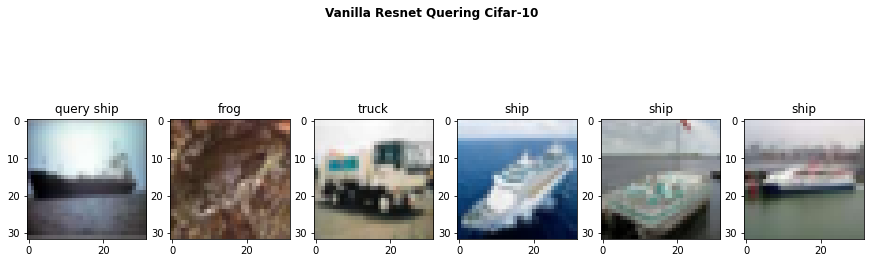

In [ ]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Vanilla Resnet Quering Cifar-10', fontweight ="bold")
no_of_images = top_n+1

ax = fig.add_subplot(1, no_of_images, 1)
ax.imshow(de_normalized(target))
ax.set_title('query {}'.format(target_label))

for i in range(1, no_of_images):
    ax = fig.add_subplot(1, no_of_images, i+1)
    ax.imshow(de_normalized(train_dataset[ind[i-1]][0]))
    ax.set_title('{}'.format(classes[train_dataset[ind[i-1]][1]]))

**Thank you**